## Resnet18 muti sz

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

from torchvision.models import *
from torch.nn import CrossEntropyLoss
import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

## Create Data block (Try with 1/4 size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized'/os.listdir(PATH/'train_resized')[1])

In [6]:
img.shape

torch.Size([3, 150, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([150, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size//4)
        .databunch(bs=256).normalize(imagenet_stats))        

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [11]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: EmptyLabelList
,,,,
Path: data

## Try with ResNET 18

In [91]:
#f1 = partial(fbeta, thresh=0.2, beta = 1)

In [12]:
metrics_custom=[fbeta,accuracy_thresh]

In [13]:
learn=cnn_learner(data,models.resnet18,metrics=metrics_custom)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


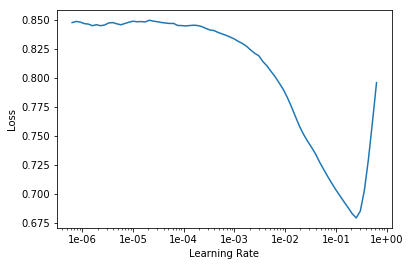

In [16]:
learn.recorder.plot()

In [14]:
lr=2e-2

In [15]:
learn.fit_one_cycle(15,slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.743298,0.568826,0.569032,0.735520,00:04
1,0.614463,0.458174,0.405448,0.804800,00:04
2,0.533986,0.415094,0.590676,0.818880,00:04
3,0.487554,0.380026,0.641067,0.832480,00:04
4,0.452468,0.374662,0.655524,0.841760,00:04
5,0.427135,0.349881,0.682209,0.846880,00:04
6,0.403883,0.340341,0.684876,0.847520,00:04
7,0.386593,0.318083,0.726233,0.862400,00:04
8,0.370408,0.310097,0.718729,0.867840,00:04
9,0.356670,0.309613,0.727705,0.864160,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

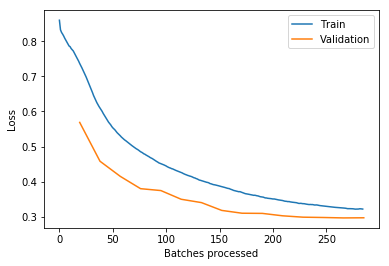

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('resnet-5-imagenet-onefrth-stage-1')

In [18]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


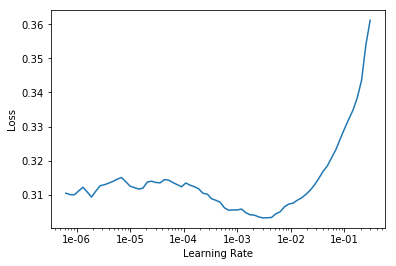

In [23]:
learn.recorder.plot()

In [19]:
lr=9e-4

In [20]:
learn.fit_one_cycle(15,slice(lr,3e-2)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.308813,0.312246,0.732229,0.874400,00:04
1,0.293181,0.343316,0.753048,0.878080,00:04
2,0.282428,0.465469,0.714457,0.868320,00:04
3,0.274935,0.315075,0.786190,0.902400,00:04
4,0.268432,0.298565,0.775433,0.890560,00:04
5,0.256725,0.471918,0.695867,0.864640,00:04
6,0.249968,0.238462,0.825257,0.900160,00:04
7,0.237754,0.247158,0.821838,0.906400,00:04
8,0.224909,0.222191,0.837524,0.914880,00:04
9,0.211568,0.197857,0.846705,0.919360,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

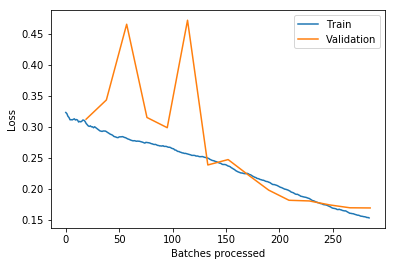

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('resnet-5-imagenet-onefrth-stage-2')

In [30]:
learn.load('resnet-5-imagenet-onefrth-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70),Image (3, 50, 70)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

## Pass 1/3rd size

In [31]:
data = (src.transform(tfms, size=src_size//3)
        .databunch(bs=256).normalize(imagenet_stats))  

In [32]:
learn.data=data

In [33]:
learn.freeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


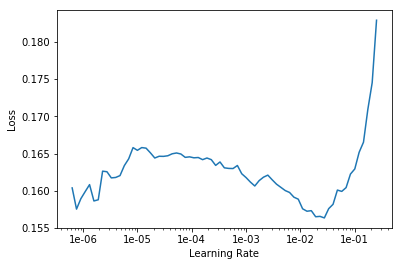

In [27]:
learn.recorder.plot()

In [34]:
lr=2e-3

In [35]:
learn.fit_one_cycle(15,max_lr=slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.163932,0.188544,0.853752,0.924480,00:05
1,0.162053,0.184215,0.855886,0.925600,00:04
2,0.160688,0.179856,0.859143,0.926880,00:04
3,0.160037,0.178497,0.860724,0.927840,00:04
4,0.161011,0.176883,0.858400,0.927840,00:04
5,0.159170,0.175323,0.861638,0.928480,00:04
6,0.155716,0.174808,0.862267,0.928640,00:04
7,0.152922,0.173249,0.864076,0.929440,00:04
8,0.151771,0.173629,0.861810,0.929760,00:04
9,0.151159,0.171478,0.865981,0.929280,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

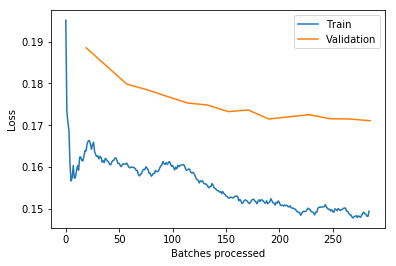

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save('resnet-5-imagenet-onethrd-stage-3')

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


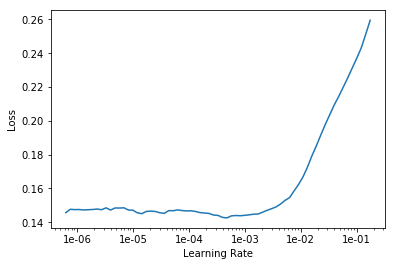

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
lr=5e-5
learn.fit_one_cycle(10,max_lr=slice(lr,2e-3)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.147701,0.166763,0.869467,0.929280,00:04
1,0.144581,0.160254,0.877333,0.933440,00:04
2,0.141078,0.155291,0.880914,0.933760,00:05
3,0.135561,0.145565,0.889810,0.941920,00:04
4,0.132625,0.144917,0.894267,0.938560,00:04
5,0.126847,0.147979,0.888057,0.940320,00:05
6,0.123048,0.144513,0.893352,0.943840,00:04
7,0.119530,0.144477,0.892857,0.943680,00:04
8,0.114695,0.144333,0.891657,0.942880,00:04
9,0.112191,0.144981,0.893200,0.943200,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

In [42]:
learn.save('resnet-5-imagenet-onethrd-stage-4')

## Pass half size

In [43]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=128).normalize(imagenet_stats))

In [44]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


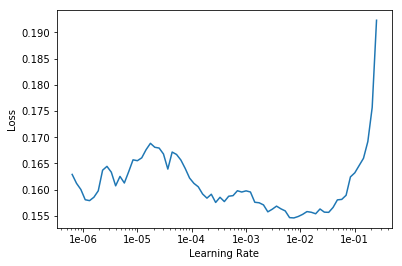

In [46]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [47]:
lr=9e-4
learn.fit_one_cycle(12,max_lr=slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.161006,0.178274,0.859238,0.927520,00:04
1,0.162539,0.172971,0.860095,0.930880,00:04
2,0.159746,0.168529,0.863486,0.930400,00:04
3,0.154729,0.165485,0.865371,0.929120,00:04
4,0.151727,0.163424,0.867738,0.931840,00:04
5,0.154290,0.161365,0.870081,0.932480,00:05
6,0.151578,0.160082,0.870614,0.932480,00:04
7,0.149786,0.160081,0.870595,0.932960,00:04
8,0.148017,0.160716,0.871524,0.933280,00:04
9,0.147049,0.159794,0.871771,0.934080,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

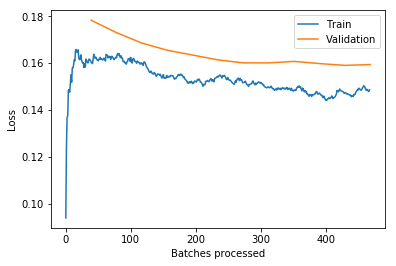

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('resnet-5-imagenet-half-stage-5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


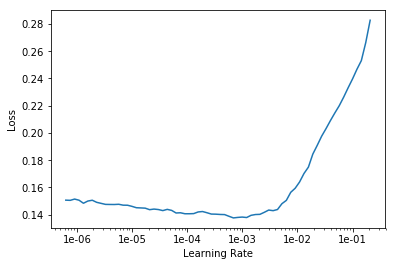

In [50]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [51]:
lr=1e-4
learn.fit_one_cycle(15,max_lr=slice(lr,9e-4)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.146411,0.154327,0.878119,0.935200,00:04
1,0.140976,0.144164,0.890362,0.939200,00:04
2,0.130391,0.141309,0.893181,0.943200,00:04
3,0.122466,0.135385,0.899372,0.949440,00:04
4,0.115228,0.131217,0.904343,0.950240,00:04
5,0.107632,0.122227,0.908557,0.952800,00:04
6,0.099373,0.126279,0.906152,0.952160,00:04
7,0.093684,0.125565,0.907067,0.954560,00:04
8,0.086460,0.123142,0.911086,0.953120,00:05
9,0.078858,0.120370,0.915029,0.956160,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

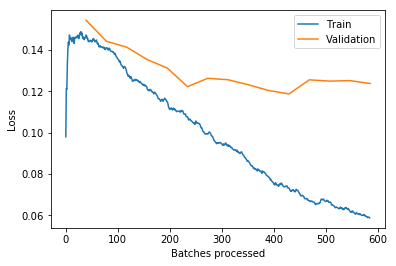

In [52]:
learn.recorder.plot_losses()

In [53]:
learn.save('resnet-5-imagenet-half-stage-6')

## Pass full size image

In [54]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [55]:
learn.data=data

In [56]:
learn.data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


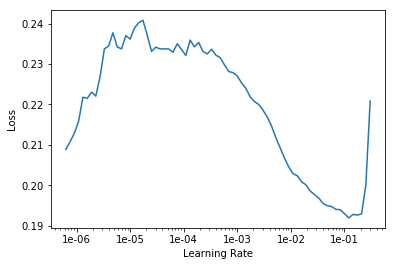

In [60]:
learn.load('resnet-5-imagenet-half-stage-6')
learn.freeze()
learn.data=data
learn.lr_find()
learn.recorder.plot()

In [61]:
lr=1e-2
learn.fit_one_cycle(15,slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.213542,0.213527,0.833429,0.918080,00:08
1,0.188349,0.182056,0.858981,0.927680,00:08
2,0.167304,0.171796,0.865448,0.930080,00:08
3,0.151357,0.156051,0.879186,0.937120,00:07
4,0.139012,0.146499,0.883105,0.940960,00:07
5,0.126276,0.152672,0.884214,0.940960,00:07
6,0.116778,0.143261,0.888800,0.945760,00:07
7,0.112207,0.135067,0.895429,0.945600,00:08
8,0.107139,0.129903,0.900533,0.948000,00:08
9,0.102742,0.129255,0.900857,0.949120,00:08


AttributeError: 'NoneType' object has no attribute 'mixup'

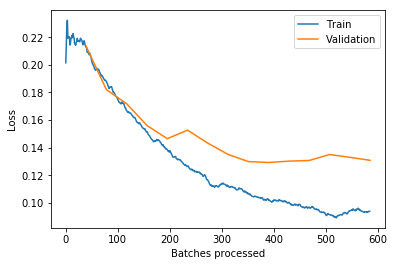

In [63]:
learn.recorder.plot_losses()

In [62]:
learn.save('resnet-5-imagenet-full-stage-7')

In [66]:
learn.load('resnet-5-imagenet-full-stage-7')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

Traceback (most recent call last):
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 404, in _send_by

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


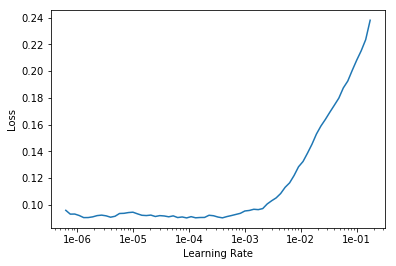

In [64]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [67]:
lr=3e-5
learn.fit_one_cycle(20,max_lr=slice(lr,1e-3)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.090513,0.130728,0.900838,0.950080,00:08
1,0.089171,0.127840,0.904857,0.950720,00:08
2,0.086384,0.127350,0.902914,0.950560,00:08
3,0.081766,0.121670,0.909886,0.952320,00:08
4,0.077833,0.118730,0.915733,0.955360,00:07
5,0.077677,0.130676,0.908571,0.951840,00:07
6,0.071955,0.115888,0.916576,0.956640,00:08
7,0.067499,0.114486,0.917467,0.958560,00:08
8,0.060455,0.110619,0.918667,0.960800,00:08
9,0.054490,0.110586,0.923543,0.963360,00:08


AttributeError: 'NoneType' object has no attribute 'mixup'

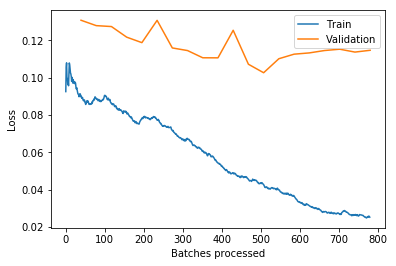

In [68]:
learn.recorder.plot_losses()

In [69]:
learn.save('resnet-5-imagenet-full-stage-8')

In [70]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [56]:
test_pred_tta

(tensor([[9.9283e-01, 2.0347e-04, 9.6460e-04, 9.0035e-04, 5.3188e-04],
         [1.4024e-03, 1.9425e-04, 9.9864e-01, 3.3871e-04, 2.0669e-04],
         [5.7922e-01, 2.0019e-02, 5.9642e-04, 6.7006e-02, 2.8913e-01],
         ...,
         [9.3079e-02, 2.2776e-04, 8.4911e-01, 5.1968e-02, 1.7440e-03],
         [1.2892e-04, 9.9938e-01, 2.5478e-05, 1.7694e-04, 8.0086e-05],
         [9.8172e-01, 3.3297e-04, 1.0101e-04, 5.6791e-05, 1.7353e-02]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [71]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 0,  ..., 2, 1, 0])

In [72]:
a=array(preds)

In [ ]:
data.test_ds.x[1]

In [73]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [74]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,1
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [75]:
len(submission)

2680

In [76]:
submission.to_csv(PATH/'submission_resnet18_multisz.csv',index=False)

## Merge the validation set

In [78]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [79]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [82]:
data

ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [84]:
learn.load('resnet-5-imagenet-full-stage-8')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

In [85]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


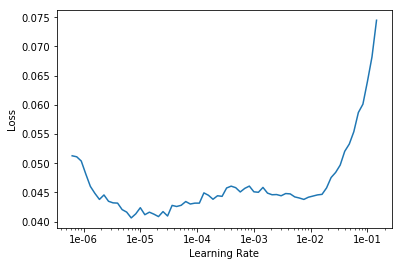

In [86]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [87]:
lr=9e-6
learn.fit_one_cycle(15,max_lr=slice(lr)).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

In [88]:
learn.save('resnet-5-imagenet-full-stage-8-noval')

In [89]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [90]:
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnet18_multisz-noval.csv',index=False)